CSV loaded with 39209 entries
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


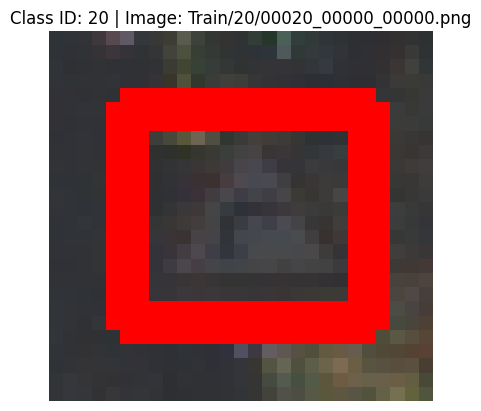

In [ ]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import warnings

BASE_DIR = "./GTSRB"  
TRAIN_CSV_PATH = os.path.join(BASE_DIR, "Train.csv")
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR, "Train")


warnings.filterwarnings("ignore")


df = pd.read_csv(TRAIN_CSV_PATH)
print("CSV loaded with", len(df), "entries")
print(df.head())


def load_image_with_bbox(row):
    image_path = os.path.join(BASE_DIR, row['Path'])
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
    label = row['ClassId']

    return img, (x1, y1, x2, y2), label

def visualize_sample(index=0):
    row = df.iloc[index]
    img, bbox, label = load_image_with_bbox(row)
    x1, y1, x2, y2 = bbox


    img_bbox = img.copy()
    cv2.rectangle(img_bbox, (x1, y1), (x2, y2), (255, 0, 0), 2)


    plt.imshow(img_bbox)
    plt.title(f'Class ID: {label} | Image: {row["Path"]}')
    plt.axis('off')
    plt.show()


visualize_sample(0)


In [2]:
class GTSRBDataset:
    def __init__(self, csv_path, base_dir, target_size=(224, 224), transform=None):
        self.df = pd.read_csv(csv_path)
        self.base_dir = base_dir
        self.transform = transform
        self.target_size = target_size  # NEW

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.base_dir, row['Path'])
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = cv2.resize(img, self.target_size)

        x_scale = self.target_size[0] / row['Width']
        y_scale = self.target_size[1] / row['Height']

        bbox = [
            int(row['Roi.X1'] * x_scale),
            int(row['Roi.Y1'] * y_scale),
            int(row['Roi.X2'] * x_scale),
            int(row['Roi.Y2'] * y_scale)
        ]

        label = row['ClassId']

        sample = {
            'image': img,
            'bbox': bbox,
            'label': label
        }

        if self.transform:
            sample = self.transform(sample)

        return sample


dataset = GTSRBDataset(TRAIN_CSV_PATH, BASE_DIR)

sample = dataset[0]
print("Image shape:", sample['image'].shape)
print("Bounding box:", sample['bbox'])
print("Label:", sample['label'])


Image shape: (224, 224, 3)
Bounding box: [41, 43, 182, 172]
Label: 20


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

class TrafficSignDetector(nn.Module):
    def __init__(self, num_classes=43):
        super(TrafficSignDetector, self).__init__()

        backbone = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = backbone.features  

        self.bbox_regressor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, 4)  # x1, y1, x2, y2
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        bbox = self.bbox_regressor(features)
        class_logits = self.classifier(features)
        return bbox, class_logits


In [4]:
import torch.nn.functional as F

def compute_loss(pred_bbox, true_bbox, pred_logits, true_labels):
    bbox_loss = F.smooth_l1_loss(pred_bbox, true_bbox.float())

    cls_loss = F.cross_entropy(pred_logits, true_labels.long())
    total_loss = bbox_loss + cls_loss
    return total_loss, bbox_loss, cls_loss


In [5]:

pred_bbox = torch.randn(4, 4)      
true_bbox = torch.randn(4, 4)

pred_logits = torch.randn(4, 43) 
true_labels = torch.randint(0, 43, (4,))


total_loss, bbox_loss, cls_loss = compute_loss(pred_bbox, true_bbox, pred_logits, true_labels)
print(f"Total Loss: {total_loss.item()}, BBox Loss: {bbox_loss.item()}, Class Loss: {cls_loss.item()}")


Total Loss: 5.026495456695557, BBox Loss: 0.658660352230072, Class Loss: 4.36783504486084


In [6]:
def custom_collate_fn(batch):
    images = []
    bboxes = []
    labels = []

    for item in batch:
        images.append(torch.tensor(item['image']).permute(2, 0, 1).float() / 255.0)
        bboxes.append(torch.tensor(item['bbox']).float())
        labels.append(torch.tensor(item['label']).long())

    images = torch.stack(images)
    bboxes = torch.stack(bboxes)
    labels = torch.stack(labels)

    return {'image': images, 'bbox': bboxes, 'label': labels}


Using device: cuda


Training Epoch 1: 100%|██████████| 3921/3921 [02:11<00:00, 29.76it/s]


Epoch 1: Train Loss = 25.9514, Val Loss = 2.1721


Training Epoch 2: 100%|██████████| 3921/3921 [01:55<00:00, 33.81it/s]


Epoch 2: Train Loss = 2.4210, Val Loss = 1.7433


Training Epoch 3: 100%|██████████| 3921/3921 [01:55<00:00, 33.80it/s]


Epoch 3: Train Loss = 1.9007, Val Loss = 1.5525


Training Epoch 4: 100%|██████████| 3921/3921 [01:56<00:00, 33.77it/s]


Epoch 4: Train Loss = 1.6350, Val Loss = 1.5731


Training Epoch 5: 100%|██████████| 3921/3921 [01:56<00:00, 33.79it/s]


Epoch 5: Train Loss = 1.5100, Val Loss = 1.5159


Training Epoch 6: 100%|██████████| 3921/3921 [01:56<00:00, 33.55it/s]


Epoch 6: Train Loss = 1.4204, Val Loss = 1.8218


Training Epoch 7: 100%|██████████| 3921/3921 [01:56<00:00, 33.57it/s]


Epoch 7: Train Loss = 1.3645, Val Loss = 1.5879


Training Epoch 8: 100%|██████████| 3921/3921 [01:56<00:00, 33.53it/s]


Epoch 8: Train Loss = 1.3044, Val Loss = 1.4923


Training Epoch 9: 100%|██████████| 3921/3921 [01:56<00:00, 33.70it/s]


Epoch 9: Train Loss = 1.2533, Val Loss = 1.4281


Training Epoch 10: 100%|██████████| 3921/3921 [02:02<00:00, 32.00it/s]


Epoch 10: Train Loss = 1.2132, Val Loss = 1.2646


Training Epoch 11: 100%|██████████| 3921/3921 [02:03<00:00, 31.73it/s]


Epoch 11: Train Loss = 1.1634, Val Loss = 1.3236


Training Epoch 12: 100%|██████████| 3921/3921 [02:01<00:00, 32.33it/s]


Epoch 12: Train Loss = 1.1224, Val Loss = 1.2733


Training Epoch 13: 100%|██████████| 3921/3921 [02:01<00:00, 32.25it/s]


Epoch 13: Train Loss = 1.0803, Val Loss = 1.2573


Training Epoch 14: 100%|██████████| 3921/3921 [01:58<00:00, 32.97it/s]


Epoch 14: Train Loss = 1.0471, Val Loss = 1.2208


Training Epoch 15: 100%|██████████| 3921/3921 [02:00<00:00, 32.43it/s]


Epoch 15: Train Loss = 1.0084, Val Loss = 1.4131


Training Epoch 16: 100%|██████████| 3921/3921 [02:00<00:00, 32.62it/s]


Epoch 16: Train Loss = 0.9699, Val Loss = 1.5366


Training Epoch 17: 100%|██████████| 3921/3921 [01:59<00:00, 32.69it/s]


Epoch 17: Train Loss = 0.9401, Val Loss = 1.2340


Training Epoch 18: 100%|██████████| 3921/3921 [02:02<00:00, 32.10it/s]


Epoch 18: Train Loss = 0.9081, Val Loss = 1.4142


Training Epoch 19: 100%|██████████| 3921/3921 [01:57<00:00, 33.42it/s]


Epoch 19: Train Loss = 0.8763, Val Loss = 1.2957
Early stopping triggered.


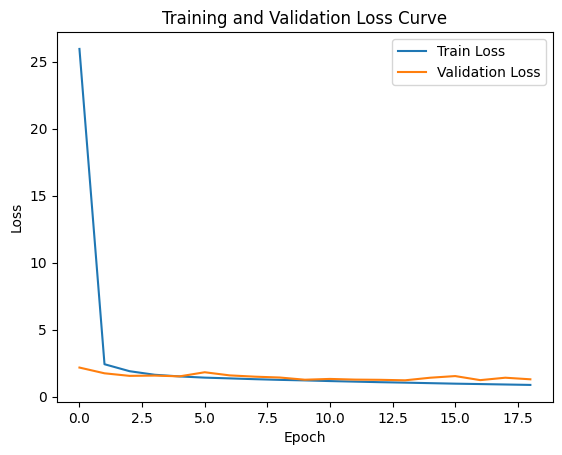

In [7]:
from torch.utils.data import random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


validation_ratio = 0.2
total_size = len(dataset)
val_size = int(total_size * validation_ratio)
train_size = total_size - val_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)


model = TrafficSignDetector(num_classes=43).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(50):
    model.train()
    total_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images = batch['image'].to(device)
        true_bboxes = batch['bbox'].float().to(device)
        true_labels = batch['label'].long().to(device)

        pred_bboxes, pred_logits = model(images)
        loss, bbox_loss, cls_loss = compute_loss(pred_bboxes, true_bboxes, pred_logits, true_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            true_bboxes = batch['bbox'].float().to(device)
            true_labels = batch['label'].long().to(device)

            pred_bboxes, pred_logits = model(images)
            loss, _, _ = compute_loss(pred_bboxes, true_bboxes, pred_logits, true_labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

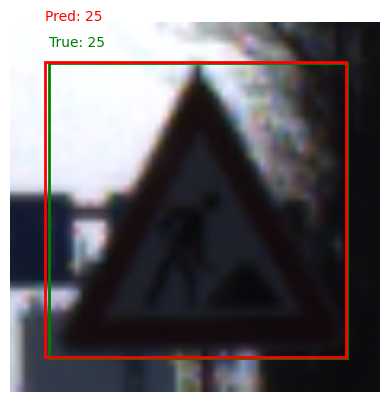

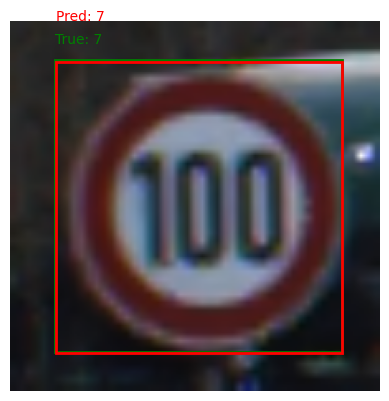

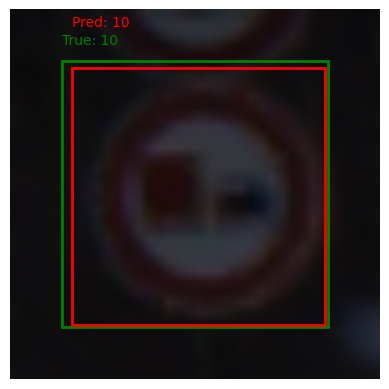

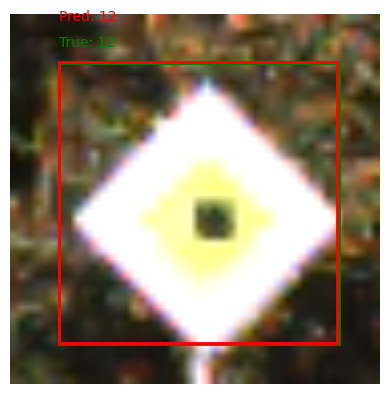

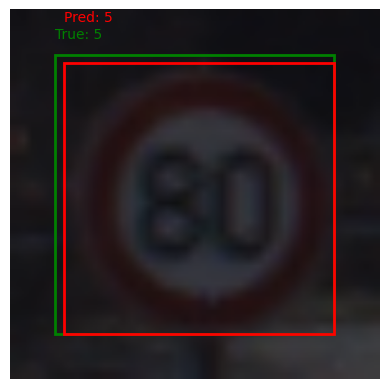

In [15]:
import matplotlib.patches as patches


model.load_state_dict(torch.load("best_model.pth"))
model.eval()

def visualize_detection(sample, idx=0):
    image_np = sample['image'].numpy().transpose(1, 2, 0) * 255.0
    image_np = image_np.astype('uint8')

    true_bbox = sample['bbox']
    true_label = sample['label']


    image_tensor = sample['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        pred_bbox, pred_logits = model(image_tensor)

    pred_bbox = pred_bbox[0].cpu().numpy()
    pred_label = pred_logits[0].argmax().item()


    fig, ax = plt.subplots(1)
    ax.imshow(image_np)


    rect_true = patches.Rectangle(
        (true_bbox[0], true_bbox[1]),
        true_bbox[2] - true_bbox[0],
        true_bbox[3] - true_bbox[1],
        linewidth=2,
        edgecolor='g',
        facecolor='none'
    )
    ax.add_patch(rect_true)
    ax.text(true_bbox[0], true_bbox[1] - 10, f"True: {true_label}", color='green')


    rect_pred = patches.Rectangle(
        (pred_bbox[0], pred_bbox[1]),
        pred_bbox[2] - pred_bbox[0],
        pred_bbox[3] - pred_bbox[1],
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect_pred)
    ax.text(pred_bbox[0], pred_bbox[1] - 25, f"Pred: {pred_label}", color='red')

    plt.axis('off')
    plt.show()


for i in range(5):
    sample = val_dataset[i]
    sample['image'] = torch.tensor(sample['image']).permute(2, 0, 1).float() / 255.0  # Ensure tensor format
    visualize_detection(sample, idx=i)


In [16]:

TEST_CSV_PATH = os.path.join(BASE_DIR, "Test.csv")
TEST_IMAGES_DIR = os.path.join(BASE_DIR, "Test")

test_dataset = GTSRBDataset(TEST_CSV_PATH, BASE_DIR)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)


In [17]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

total_test_loss = 0.0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on Test Set"):
        images = batch['image'].to(device)
        true_bboxes = batch['bbox'].float().to(device)
        true_labels = batch['label'].long().to(device)

        pred_bboxes, pred_logits = model(images)
        loss, _, _ = compute_loss(pred_bboxes, true_bboxes, pred_logits, true_labels)
        total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")


Evaluating on Test Set: 100%|██████████| 1579/1579 [00:20<00:00, 75.20it/s]

Test Loss: 1.3539


In [18]:
TEST_CSV_PATH = os.path.join(BASE_DIR, "Test.csv")  
TEST_IMAGES_DIR = os.path.join(BASE_DIR) 

test_dataset = GTSRBDataset(TEST_CSV_PATH, TEST_IMAGES_DIR)

sample_row = pd.read_csv(TEST_CSV_PATH).iloc[0]
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)


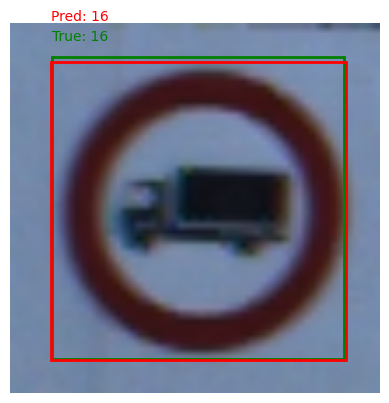

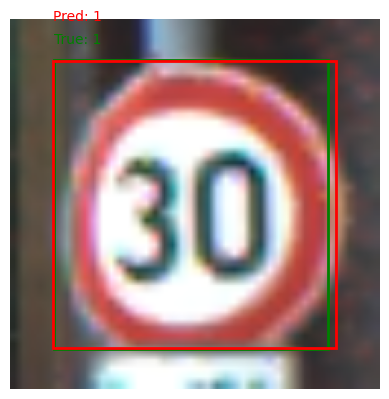

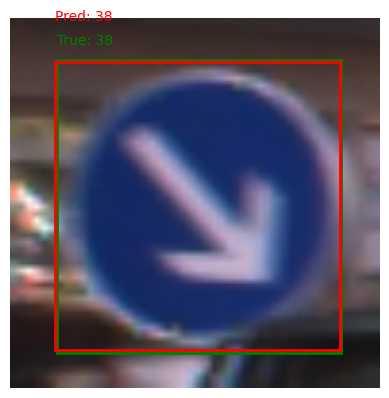

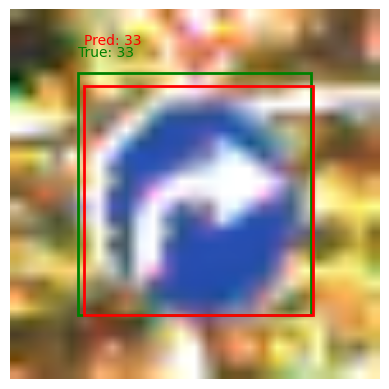

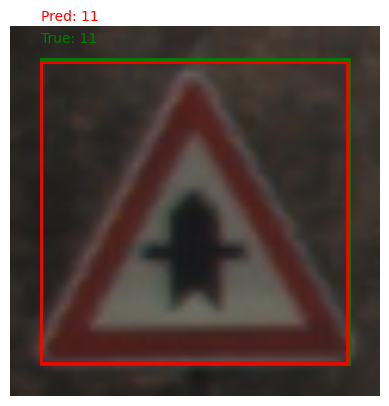

In [19]:

model.load_state_dict(torch.load("best_model.pth"))
model.eval()


for i in range(5):
    sample = test_dataset[i]
    
    sample['image'] = torch.tensor(sample['image']).permute(2, 0, 1).float() / 255.0

    visualize_detection(sample, idx=i)


In [20]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Computing Classification Accuracy"):
        images = batch['image'].to(device)
        true_labels = batch['label'].to(device)

        _, pred_logits = model(images)
        predicted_labels = torch.argmax(pred_logits, dim=1)

        correct += (predicted_labels == true_labels).sum().item()
        total += true_labels.size(0)

accuracy = correct / total * 100
print(f"Classification Accuracy on Test Set: {accuracy:.2f}%")


Computing Classification Accuracy: 100%|██████████| 1579/1579 [00:20<00:00, 75.29it/s]

Classification Accuracy on Test Set: 98.99%


In [21]:
def compute_iou(box1, box2):

    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

total_iou = 0
count = 0

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Computing Average IoU"):
        images = batch['image'].to(device)
        true_bboxes = batch['bbox'].to(device)

        pred_bboxes, _ = model(images)

        for i in range(images.size(0)):
            iou = compute_iou(pred_bboxes[i].cpu().numpy(), true_bboxes[i].cpu().numpy())
            total_iou += iou
            count += 1

average_iou = total_iou / count
print(f"Average IoU on Test Set: {average_iou:.4f}")


Computing Average IoU: 100%|██████████| 1579/1579 [00:22<00:00, 71.00it/s]

Average IoU on Test Set: 0.9589
